<a href="https://colab.research.google.com/github/maxGrigorenko/DistributionClassifier/blob/main/src/normal_laplace/experiments_second_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация распределений. Второая часть проекта,
## Построение собственного классификатора

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from scipy import stats as st

from graph_common_functions import *
from distibution_functions import *

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

class DistribituionClassifier:
    def __init__(self, n, clf, sigma=1, beta=(1/2) ** 0.5):
        self.n = n
        self.sigma = sigma
        self.beta = beta
        self.clf = clf


    def make_data(self, number_of_experiments):
        n = self.n

        data = pd.DataFrame()

        sub_data = []
        features = ['delta', 'mean_degree', 'max_degree', 'dominating_number', 'clique_number']

        for disrtibution in 'normal', 'laplace':
            for _ in range(number_of_experiments):
                if disrtibution == 'normal':
                    array = generate_normal(self.sigma, n)
                else:
                    array = generate_laplace(self.beta, n)

                features_d = []

                for d in [0.3, 1.0, 2.0, 3.5]:
                    g = distance_graph_constructor(array, d)
                    delta = g.compute_delta()
                    mean_degree = g.compute_mean_degree()
                    max_degree = g.compute_max_degree()
                    dominating_number = g.compute_dominating_number(d)
                    clique_number = g.compute_clique_number(d)
                    features_d.append([delta, mean_degree, max_degree, dominating_number, clique_number])

                params = dict()
                for i in range(len(features_d)):
                    for j, f in enumerate(features):
                        params.update({f"{f}_{i}": features_d[i][j]})

                params.update({"distribution": disrtibution})
                sub_data.append(params)

        data = pd.concat([data, pd.DataFrame(sub_data)], ignore_index=True)
        return data

    def fit(self, number_of_experiments=1000):
        data = self.make_data(number_of_experiments=number_of_experiments)
        X = data.drop('distribution', axis=1)
        y = data['distribution']
        y = [int(r == 'laplace') for r in y]
        # 'normal' --> 0
        # 'laplace' --> 1
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def estimate(self, number_of_test=100):
        data = self.make_data(number_of_experiments=number_of_test)
        X_test = data.drop('distribution', axis=1)
        y = data['distribution']
        y_test = [int(r == 'laplace') for r in y]
        y_pred = np.array(self.clf.predict(X_test))
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall
        }


Протестируем с классификатором RandomForest:

In [ ]:
d_clf_25 = DistribituionClassifier(n=25, clf=RandomForestClassifier())
d_clf_25.fit(number_of_experiments=1_000)
d_clf_25.estimate(1_000)

{'accuracy': 0.7585, 'precision': 0.7706806282722513, 'recall': 0.736}

In [ ]:
d_clf_100 = DistribituionClassifier(n=100, clf=RandomForestClassifier())
d_clf_100.fit(number_of_experiments=100)
d_clf_100.estimate(100)

{'accuracy': 0.935, 'precision': 0.9142857142857143, 'recall': 0.96}

In [ ]:
d_clf_500 = DistribituionClassifier(n=500, clf=RandomForestClassifier())
d_clf_500.fit(number_of_experiments=100)
d_clf_500.estimate(100)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}

Хорошо, попробуем подобрать гиперпараметры случайного леса, чтобы максимизировать точность.

100%|██████████| 60/60 [00:42<00:00,  1.41it/s]


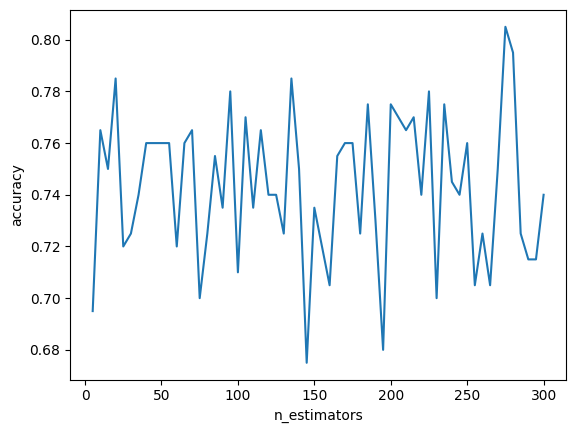

In [ ]:
n_arr = []
acc_arr = []
for n_estimators in tqdm(range(5, 300+1, 5)):
    d_clf_25 = DistribituionClassifier(n=25, clf=RandomForestClassifier(n_estimators=n_estimators))
    d_clf_25.fit(number_of_experiments=100)
    acc = d_clf_25.estimate(100)['accuracy']
    n_arr.append(n_estimators)
    acc_arr.append(acc)

plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.plot(n_arr, acc_arr)
plt.show()

Видно, что гиперпараметр n_estimators почти не влияет на точность, поэтому зафиксируем n_estimators=100 (значение по умолчанию)

Опытным путем выяснено, что при n = 25 при разных гиперпараметрах точность меняется слабо, видимо, из-за того, что при 25 точках слишком мало признаков для отличия распределения случайным лесом, поэтому будем подбирать гиперпараметры при n = 100

In [ ]:
max_acc = 0
best_max_depth = -1
best_min_samples_split = -1
for max_depth in range(3, 20):
    for min_samples_split in range(2, 15):
        forest = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        d_clf_100 = DistribituionClassifier(n=100, clf=forest)
        d_clf_100.fit(number_of_experiments=300)
        acc = d_clf_100.estimate(1000)['accuracy']
        if acc > max_acc:
            max_acc = acc
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            print(f"acc={acc}, max_depth={max_depth}, min_samples_split={min_samples_split}")

acc=0.936, max_depth=3, min_samples_split=2
acc=0.9405, max_depth=3, min_samples_split=4
acc=0.945, max_depth=3, min_samples_split=7
acc=0.947, max_depth=3, min_samples_split=8
acc=0.949, max_depth=4, min_samples_split=4
acc=0.955, max_depth=4, min_samples_split=8
acc=0.956, max_depth=9, min_samples_split=13
acc=0.958, max_depth=10, min_samples_split=12


Код выполняется очень долго, запигем выводы:

acc=0.936, max_depth=3, min_samples_split=2.  
acc=0.9405, max_depth=3, min_samples_split=4.  
acc=0.945, max_depth=3, min_samples_split=7.  
acc=0.947, max_depth=3, min_samples_split=8.  
acc=0.949, max_depth=4, min_samples_split=4.  
acc=0.955, max_depth=4, min_samples_split=8.  
acc=0.956, max_depth=9, min_samples_split=13.  
acc=0.958, max_depth=10, min_samples_split=12.  

In [8]:
best_max_depth = 10
best_min_samples_split = 12

In [ ]:
d_clf_random = DistribituionClassifier(n=25, clf=RandomForestClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split))
d_clf_random.fit(number_of_experiments=1000)
d_clf_random.estimate(1000)

{'accuracy': 0.7715, 'precision': 0.7909967845659164, 'recall': 0.738}

In [ ]:
d_clf_random = DistribituionClassifier(n=100, clf=RandomForestClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split))
d_clf_random.fit(number_of_experiments=100)
d_clf_random.estimate(100)

{'accuracy': 0.95, 'precision': 0.9411764705882353, 'recall': 0.96}

In [ ]:
d_clf_random = DistribituionClassifier(n=500, clf=RandomForestClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split))
d_clf_random.fit(number_of_experiments=100)
d_clf_random.estimate(100)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}

Точность немного увеличилась

In [ ]:
from sklearn.ensemble import BaggingClassifier

d_clf_random = DistribituionClassifier(n=25, clf=BaggingClassifier())
d_clf_random.fit(number_of_experiments=1000)
d_clf_random.estimate(1000)

{'accuracy': 0.7475, 'precision': 0.7624602332979852, 'recall': 0.719}

Точность немного ниже, чем у RandomForest. Попробуем перебрать гиперпарметр n_estimators

100%|██████████| 60/60 [04:43<00:00,  4.73s/it]


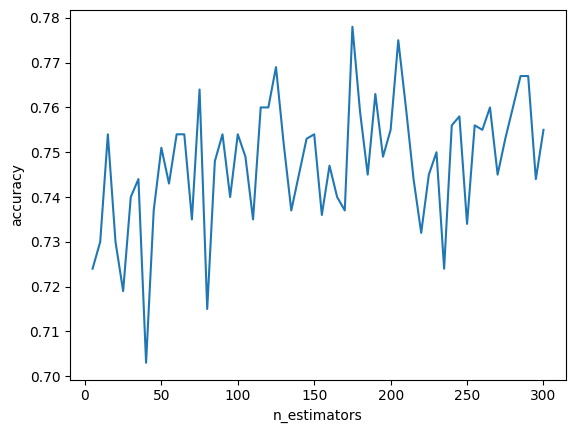

In [ ]:
n_arr = []
acc_arr = []
for n_estimators in tqdm(range(5, 300+1, 5)):
    d_clf_25 = DistribituionClassifier(n=25, clf=BaggingClassifier(n_estimators=n_estimators))
    d_clf_25.fit(number_of_experiments=1_000)
    acc = d_clf_25.estimate(500)['accuracy']
    n_arr.append(n_estimators)
    acc_arr.append(acc)

plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.plot(n_arr, acc_arr)
plt.show()

Возьмем n_estimators = 300

In [ ]:
d_clf_25 = DistribituionClassifier(n=25, clf=BaggingClassifier(n_estimators=300))
d_clf_25.fit(1_000)
d_clf_25.estimate(1_000)

{'accuracy': 0.745, 'precision': 0.7578947368421053, 'recall': 0.72}

In [ ]:
d_clf_100 = DistribituionClassifier(n=100, clf=BaggingClassifier(n_estimators=300))
d_clf_100.fit(1_000)
d_clf_100.estimate(1_000)

{'accuracy': 0.9435, 'precision': 0.9448345035105316, 'recall': 0.942}

In [ ]:
d_clf_500 = DistribituionClassifier(n=500, clf=BaggingClassifier(n_estimators=300))
d_clf_500.fit(100)
d_clf_500.estimate(100)

{'accuracy': 0.995, 'precision': 1.0, 'recall': 0.99}

Точность чуть ниже, чем у RandomForest. У всех классификаторов очень высокая точность при n = 500, посмотрим на данные, которые получаеются при таком значении n:

In [ ]:
d_clf_500.make_data(10)

,delta_0,mean_degree_0,max_degree_0,dominating_number_0,clique_number_0,delta_1,mean_degree_1,max_degree_1,dominating_number_1,clique_number_1,...,mean_degree_2,max_degree_2,dominating_number_2,clique_number_2,delta_3,mean_degree_3,max_degree_3,dominating_number_3,clique_number_3,distribution
0,0,87.128,133,11,76,6,267.368,361,4,209,...,423.972,477,2,362,279,491.904,499,1,460,normal
1,0,84.232,127,12,70,3,259.144,347,4,206,...,420.952,478,2,349,247,492.572,499,1,463,normal
2,1,85.180,128,9,76,28,263.372,354,3,197,...,426.916,486,2,357,418,495.216,499,1,464,normal
3,0,84.992,132,11,77,6,260.992,348,4,210,...,420.416,477,2,349,296,492.292,499,1,460,normal
4,0,83.504,127,12,72,0,259.108,344,5,196,...,419.732,479,3,345,59,491.456,498,2,463,normal
5,0,83.740,125,11,75,2,260.544,350,4,194,...,421.404,478,2,351,295,492.500,499,1,461,normal
6,0,82.384,125,11,70,0,257.784,345,5,206,...,417.652,474,2,346,143,490.780,498,2,459,normal
7,2,78.664,125,10,76,21,245.848,324,3,187,...,409.420,476,2,325,369,491.832,499,1,456,normal
8,0,85.344,126,12,70,4,263.948,348,4,198,...,423.760,482,2,349,249,492.568,499,1,467,normal
9,0,87.060,132,11,74,9,269.128,356,3,205,...,428.788,480,2,357,355,494.148,499,1,464,normal


Некоторые признаки действительно сильно различаются при разных распределениях, поэтому высокая точность не удивляет.   

Мощность классификатора равна метрике recall по определению. В лучшем случае (случайный лес) при n = 25 составляет примерно 74%, при n = 100 в районе 96% и при n = 500 самая высокая: 99-100%

Посчитаем ошибку первого рода и важность признаков:

In [9]:
d_clf_best_25 = DistribituionClassifier(n=25, clf=RandomForestClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split))
d_clf_best_25.fit(number_of_experiments=1000)

df = d_clf_best_25.make_data(1000)
only_normal= df[df['distribution'] == 'normal']
X = only_normal.drop('distribution', axis=1)
laplace_incorrect = sum(d_clf_best_25.clf.predict(X))
err = round(laplace_incorrect/1000, 3)
print(f"error={100 * float(err)}%")

error=22.3%


In [10]:
d_clf_best_100 = DistribituionClassifier(n=100, clf=RandomForestClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split))
d_clf_best_100.fit(number_of_experiments=1000)

df = d_clf_best_100.make_data(1000)
only_normal= df[df['distribution'] == 'normal']
X = only_normal.drop('distribution', axis=1)
laplace_incorrect = sum(d_clf_best_100.clf.predict(X))
err = round(laplace_incorrect/1000, 3)
print(f"error={100 * float(err)}%")

error=5.5%


In [11]:
d_clf_best_500 = DistribituionClassifier(n=500, clf=RandomForestClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split))
d_clf_best_500.fit(number_of_experiments=100)

df = d_clf_best_500.make_data(100)
only_normal= df[df['distribution'] == 'normal']
X = only_normal.drop('distribution', axis=1)
laplace_incorrect = sum(d_clf_best_500.clf.predict(X))
err = round(laplace_incorrect/100, 2)
print(f"error={100 * float(err)}%")

error=0.0%


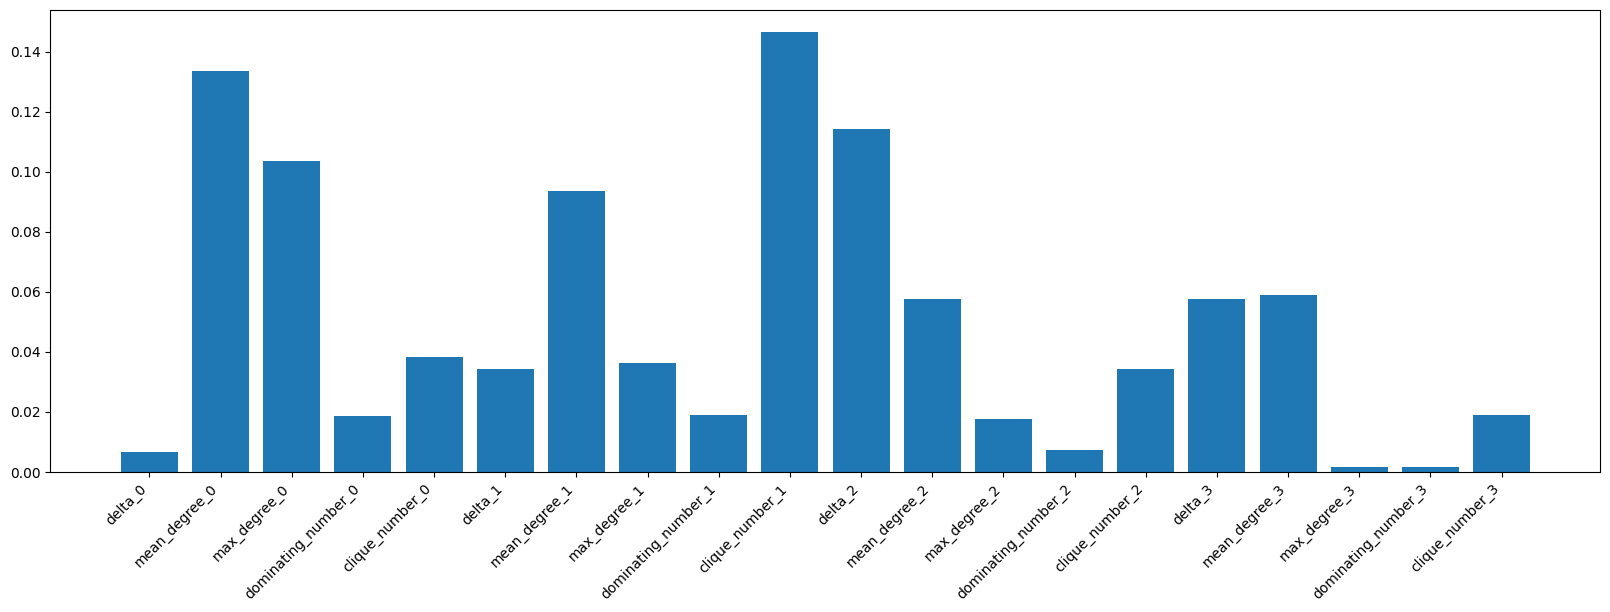

In [17]:
feature_importances_25 = d_clf_best_25.clf.feature_importances_
plt.figure(figsize=(20, 6))
plt.xticks(rotation=45, ha='right')
plt.bar(X.columns, feature_importances_25)
plt.show()

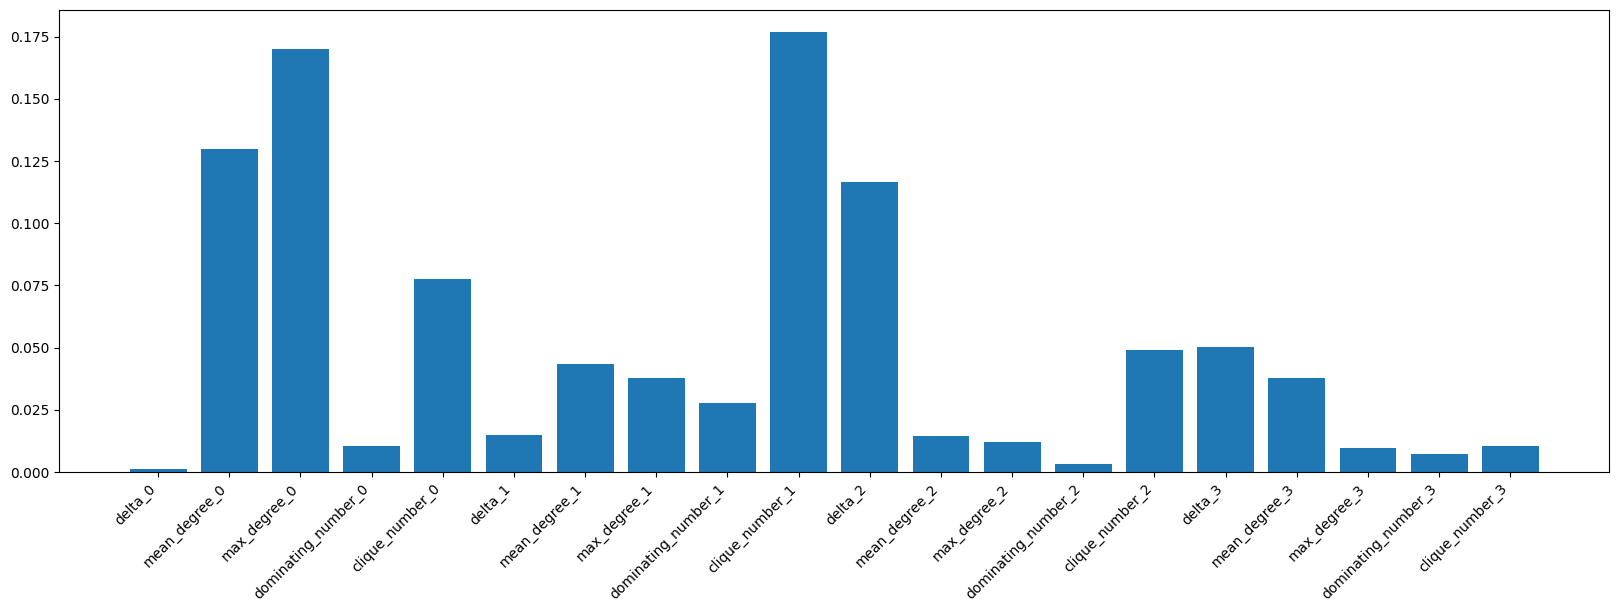

In [18]:
feature_importances_100 = d_clf_best_100.clf.feature_importances_
plt.figure(figsize=(20, 6))
plt.xticks(rotation=45, ha='right')
plt.bar(X.columns, feature_importances_100)
plt.show()

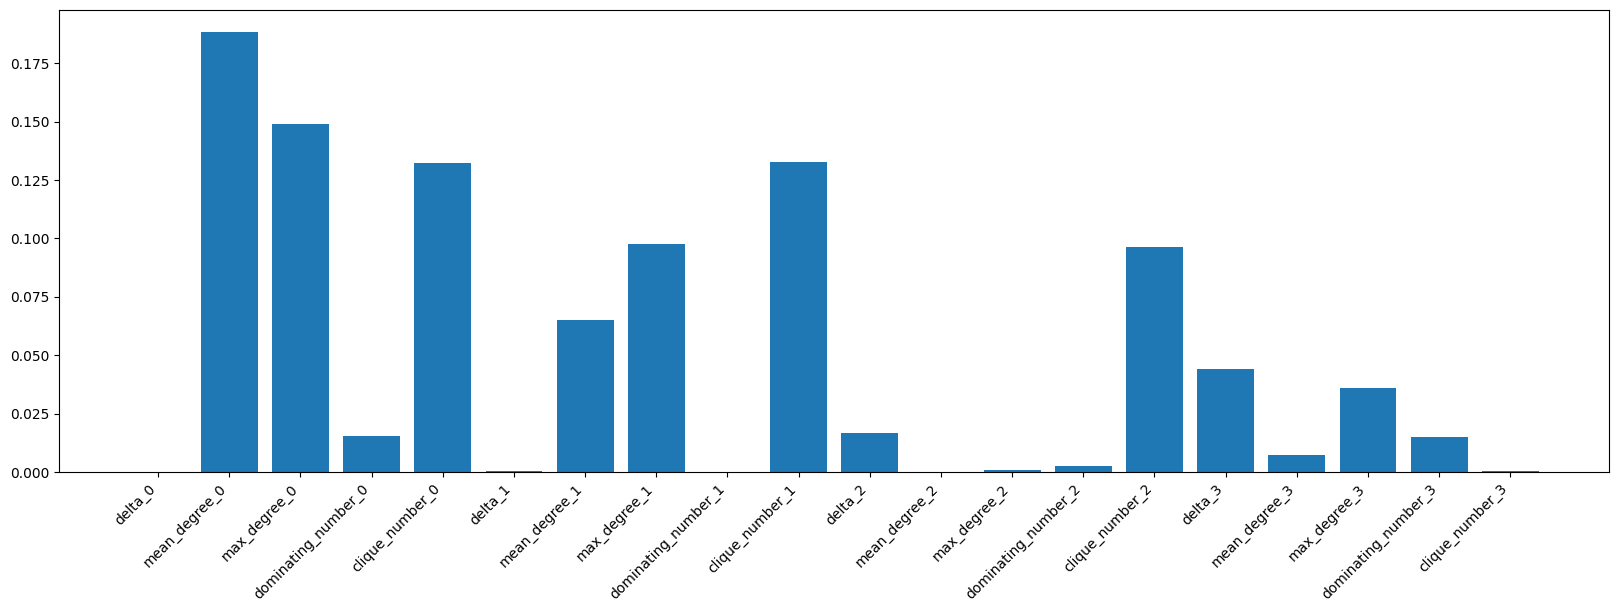

In [19]:
feature_importances_500 = d_clf_best_500.clf.feature_importances_
plt.figure(figsize=(20, 6))
plt.xticks(rotation=45, ha='right')
plt.bar(X.columns, feature_importances_500)
plt.show()

Важность характеристик слабо меняется при увеличении n, самые заметные изменения заключается в снижении значимости характеристик дистанционного графа с d = 2.0 за исключением кликового числа; во всех случаях самыми важными характеристиками оказались средняя и максимальная степени дистанционного графа при d = 0.3, а также кликовое число при d = 1.0. При n = 25 также важной характеристикой является минимальная степень при d = 2.0, а при n = 500 - кликовое число при d = 0.3